# ================================
# Building a Robot Judge - Assignment 1
## Matthäus Heer
# ================================

# Import section

In [166]:
%load_ext autoreload
%autoreload 2

import os
import random
from collections import Counter
from pprint import pprint
from textwrap import indent
import matplotlib

import spacy
import nltk
from nltk.corpus import stopwords
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt

from context import robot_judge  # Now we can use all the handy robot_judge functionality :-)
from robot_judge.io import ProblemSet1Io
from robot_judge.nlp.language_models import spacy_nlp_en, stop_words
from robot_judge.utils import indent as indent_text

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# How-To

1) In the repo root directory there is a folder called _data_.  
2) Go there and create a folder called *assignment_1* (or whatever the DATA_DIR_NAME variable below is assigned to).   
3) Place all cases files (*1936_X9VD8L.txt*, ...) in there.  
4) Place the *case_reversed.csv* file in there.  
5) Run the code below.  

In [2]:
N_SAMPLED_CASES = 1000  # How many cases should be sampled to work on.
DATA_DIR_NAME = 'assignment_1'

io = ProblemSet1Io(data_dir=DATA_DIR_NAME)
corpus_dict = io.read_multiple_cases_files(n_samples=N_SAMPLED_CASES, random_seed=1)

# Process the corpus or load preprocessed corpus

In [7]:
from robot_judge.exploration.corpus_analysis import process_corpus_dict_to_doc_dict, load_doc_dict, store_doc_dict

In [5]:
PROCESS = True  # Set to True if you want to process the corpus_dict loaded above
LOAD = False  # Set to True if a processed pickle file exists and you simply want to load it (saves a lot of time)

if PROCESS and not LOAD:
    %time doc_dict = process_corpus_dict_to_doc_dict(corpus_dict, store=False, n_threads=4)
elif not PROCESS and LOAD:
    doc_dict = load_doc_dict()
else:
    print('Chose either PROCESS or LOAD to be true.')

Finished 1.0 of 100.0 batches.
Finished 2.0 of 100.0 batches.
Finished 3.0 of 100.0 batches.
Finished 4.0 of 100.0 batches.
Finished 5.0 of 100.0 batches.
Finished 6.0 of 100.0 batches.
Finished 7.0 of 100.0 batches.
Finished 8.0 of 100.0 batches.
Finished 9.0 of 100.0 batches.
Finished 10.0 of 100.0 batches.
Finished 11.0 of 100.0 batches.
Finished 12.0 of 100.0 batches.
Finished 13.0 of 100.0 batches.
Finished 14.0 of 100.0 batches.
Finished 15.0 of 100.0 batches.
Finished 16.0 of 100.0 batches.
Finished 17.0 of 100.0 batches.
Finished 18.0 of 100.0 batches.
Finished 19.0 of 100.0 batches.
Finished 20.0 of 100.0 batches.
Finished 21.0 of 100.0 batches.
Finished 22.0 of 100.0 batches.
Finished 23.0 of 100.0 batches.
Finished 24.0 of 100.0 batches.
Finished 25.0 of 100.0 batches.
Finished 26.0 of 100.0 batches.
Finished 27.0 of 100.0 batches.
Finished 28.0 of 100.0 batches.
Finished 29.0 of 100.0 batches.
Finished 30.0 of 100.0 batches.
Finished 31.0 of 100.0 batches.
Finished 32.0 of 

In [6]:
import sys
sys.getsizeof(doc_dict)

36968

In [9]:
help(sys.getsizeof)

Help on built-in function getsizeof in module sys:

getsizeof(...)
    getsizeof(object, default) -> int
    
    Return the size of object in bytes.



In [8]:
store_doc_dict(doc_dict)

Stored doc dict to /Users/matthausheer/university/robo_judge/robot-judge/data/doc_dict.pkl


In [10]:
loaded_doc_dict = load_doc_dict()

Loading doc dict /Users/matthausheer/university/robo_judge/robot-judge/data/doc_dict.pkl
Method 'load_doc_dict' finished in 55723.37 ms.


In [11]:
len(loaded_doc_dict.keys())

1000

# Task 1
## Compute sentece, words and letters count per document and plot vs year

In [12]:
from robot_judge.exploration.corpus_analysis import count_words_sents_letters
from robot_judge.exploration.corpus_analysis import visualize_counts

In [13]:
labels, word_counts, sents_counts, letters_counts = count_words_sents_letters(doc_dict)
years = [ProblemSet1Io.get_year_from_case_title(label) for label in labels]

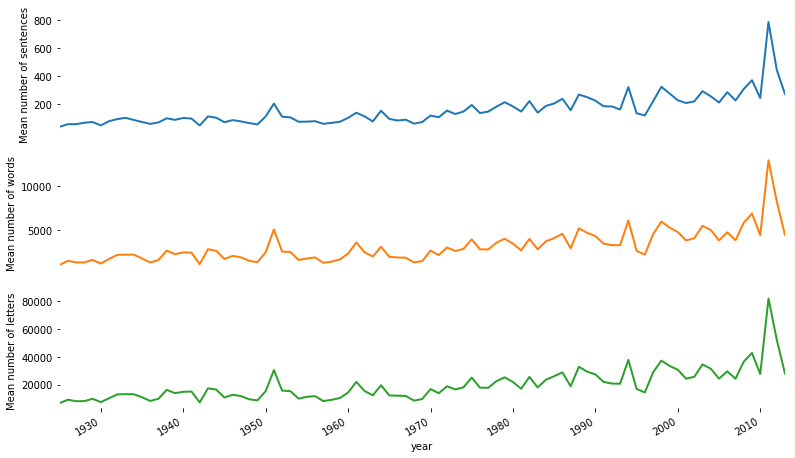

In [14]:
visualize_counts(years, word_counts, sents_counts, letters_counts)

# Task 2
## Plot part-of-speech (POS) tagging frequency vs year

In [15]:
from robot_judge.exploration.corpus_analysis import get_pos_tags
from robot_judge.exploration.corpus_analysis import aggregate_avg_pos_tags
from robot_judge.exploration.corpus_analysis import visualize_avg_pos_vs_year

In [16]:
years, pos_tags = get_pos_tags(doc_dict, ProblemSet1Io.get_year_from_case_title)

In [17]:
pos_df = aggregate_avg_pos_tags(years, pos_tags).interpolate()

<Figure size 432x288 with 0 Axes>

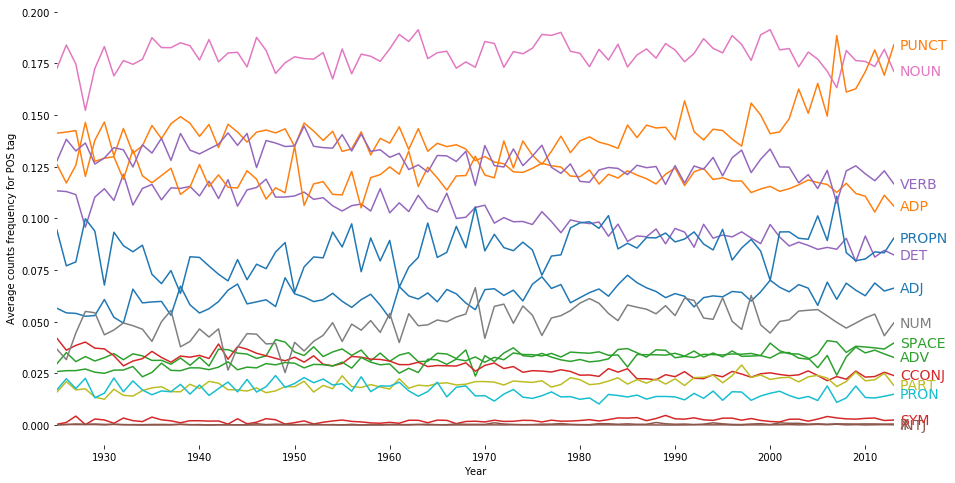

In [18]:
visualize_avg_pos_vs_year(pos_df)

# Task 3 
## Corpus normalization / cleaning & trigram creation

In [34]:
from robot_judge.nlp.ngrams import aggregate_clean_sentences, train_phrase_model, get_sents_from_sentence_dict
from gensim.models.phrases import Phrases, Phraser
from robot_judge.nlp.ngrams import print_label_sent_dict
from robot_judge.nlp.filter import token_is_punct_space
from robot_judge.utils.data_structs import flatten_list_of_lists

In [35]:
unigram_sentences_dict = aggregate_clean_sentences(doc_dict)

In [36]:
unigram_sentences = flatten_list_of_lists(get_sents_from_sentence_dict(unigram_sentences_dict)) # list (sentences) of lists (words)b

In [37]:
bigram_model = Phraser(train_phrase_model(unigram_sentences, min_count=2))

bigram_sentences = []
for sentence in unigram_sentences:
    bigram_sentences.append(bigram_model[sentence])
    
bigram_sentence_dict = {}
for label, sentences in unigram_sentences_dict.items():
    bigram_sentence_dict[label] = list(bigram_model[sentences])

In [38]:
trigram_model = Phraser(train_phrase_model(bigram_sentences, min_count=1))

trigram_sentences = []
for sentence in bigram_sentences:
    trigram_sentences.append(trigram_model[sentence])
    
trigram_sentence_dict = {}
for label, sentences in bigram_sentence_dict.items():
    trigram_sentence_dict[label] = list(trigram_model[sentences])

In [39]:
if False:  # set True for debugging
    print_label_sent_dict(trigram_sentence_dict)

# Task 4
## Create data frame of features

In [118]:
import itertools
from robot_judge.nlp.ngrams import create_df_from_label_sent_dict, get_most_common_words, filter_words
from robot_judge.nlp.ngrams import get_labels_without_year

# Index is case label, columns are words, entries are counts
feat_df = create_df_from_label_sent_dict(trigram_sentence_dict)
target_labels = get_labels_without_year(feat_df)
target_values = io.get_target_values(target_labels)
feat_df.insert(0, '__case_reversed__', target_values)
feat_df.fillna(0.0, inplace=True)

In [119]:
"""This function extracts the words which are being used as features in the classification.

Step 1: Take all the bi- and tri-gram words (words which hold one or two underline characters).
Step 2: Fill up the feature space which usual words which are the most common ones over the whole corpus.

"""
filtered_words = filter_words(trigram_sentence_dict, n_most_common=5000)

In [120]:
feat_df = feat_df[filtered_words + ['__case_reversed__']]

y = feat_df['__case_reversed__']

X = feat_df.loc[:, feat_df.columns != '__case_reversed__']

X.head()

,93_pleasant,compliance_vevraa,steam_coal,inconsistent_national_labor,wrongful_action,we_conclude_none,wife_daughter,7_14_15,reductions_prices,federal_death_penalty,...,essex_county,alabama_supra,likely_redressed,certificate_stated,answered_question_whether,414_f.supp,deposited_money,section_5845(c,319_322,nishikawa_supra_356
2006_X15139I003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1974_X42N97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1929_X3G5P8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1963_X3RLI8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1982_X3PC9F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Task 5
## Create training / test set

In [121]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [123]:
pipeline = Pipeline([('std_scaler', StandardScaler()),
                     ('log_regr', LogisticRegression())])

param_grid = {'log_regr__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

clf = GridSearchCV(pipeline, param_grid=param_grid, cv=5, refit=True)
clf = clf.fit(X_train, y_train)

In [124]:
y_pred = clf.predict(X_test)

In [125]:
print('Classification report:\n')
print(classification_report(y_test, y_pred))

Classification report:

             precision    recall  f1-score   support

          0       0.35      0.29      0.32       114
          1       0.61      0.67      0.64       186

avg / total       0.51      0.53      0.52       300



# Task 6
## GridsearchCV and ROC / AUC evaluation

In [151]:
import scikitplot as skplot

In [153]:
from robot_judge.ml import transform_to_text_label

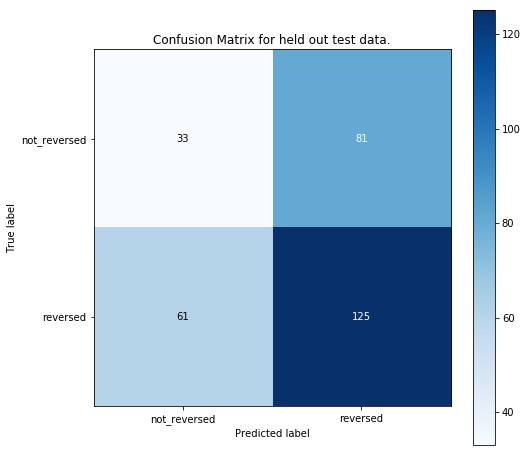

In [152]:
y_true_labels = transform_to_text_label(y_test, 'not_reversed', 'reversed')
y_pred_labels = transform_to_text_label(y_pred, 'not_reversed', 'reversed')

_ = skplot.metrics.plot_confusion_matrix(y_true_labels, y_pred_labels, figsize=(8, 8), 
                                         title="Confusion Matrix for held out test data.")

For AUC score, see plot.


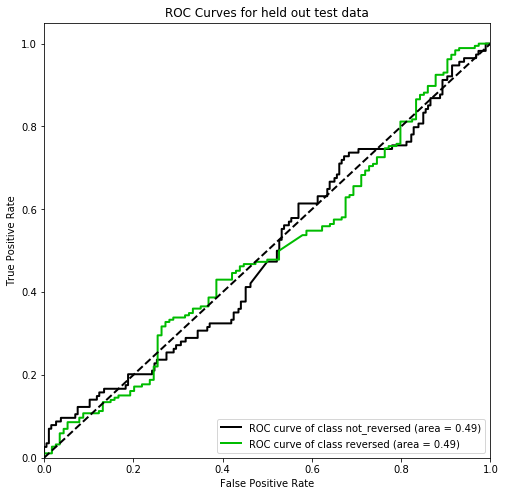

In [154]:
y_proba = clf.predict_proba(X_test)
_ = skplot.metrics.plot_roc(y_true_labels, y_proba, title='ROC Curves for held out test data', figsize=(8, 8), 
             plot_macro=False, plot_micro=False)
print('For AUC score, see plot.')

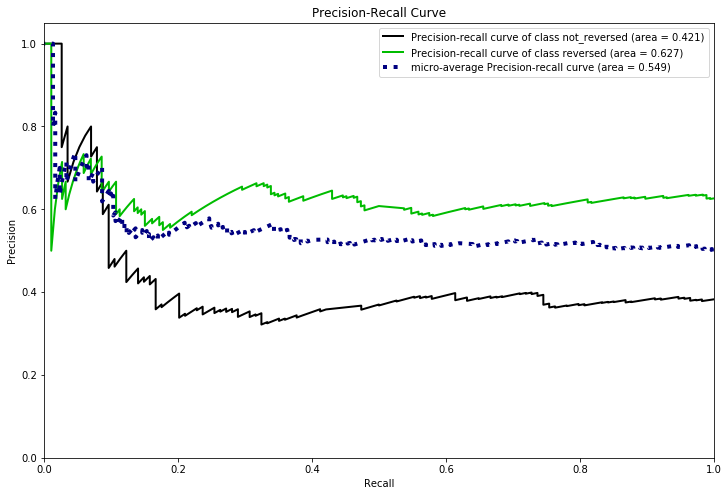

In [168]:
_ = plot_precision_recall(y_true_labels, y_proba, figsize=(12, 8))

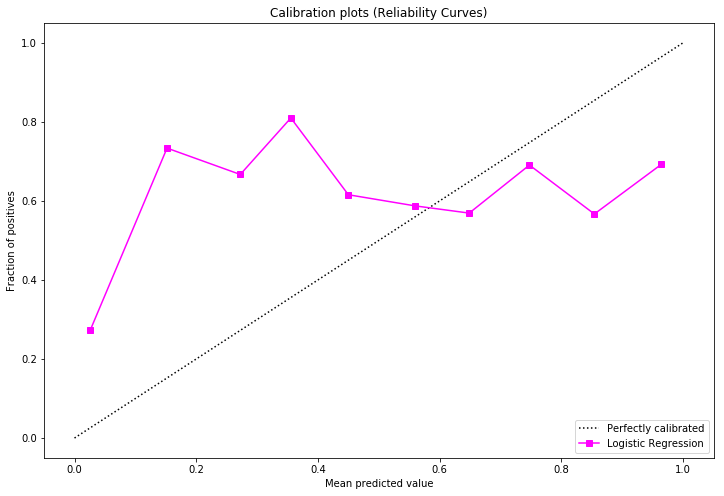

In [174]:
_ = skplot.metrics.plot_calibration_curve(y_true_labels, [y_proba], ['Logistic Regression'], 
                                          figsize=(12, 8), cmap=plt.get_cmap('spring'))

# Task 7 
## Vader compound sentiment scores

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [ ]:
%%time 

def label_case_dict_to_sentence_list(label_case_dict):
    all_sentences = []
    for case_text in sampled_cases.values():
        for sentence in spacy_nlp_en(case_text).sents:
            all_sentences.append(sentence.text)
    return all_sentences

all_sentences = label_case_dict_to_sentence_list(sampled_cases)

In [ ]:
sid = SentimentIntensityAnalyzer()

def calculate_sentiment_scores(sentences):
    sentence_scores = []
    for sentence in sentences:
        pol_score = sid.polarity_scores(sentence)
        
        score_dict = {key: value for key, value in pol_score.items()}
        score_dict['text'] = sentence
        
        sentence_scores.append(score_dict)
    return sentence_scores

sentence_scores = calculate_sentiment_scores(all_sentences[:1000])

sent_df = pd.DataFrame(sentence_scores).sort_values(by='pos', ascending=False)
print('Most POSITIVE sentences:')
for idx, sent in enumerate(sent_df['text'][:10]):
    print('\t', idx, sent)

sent_df = pd.DataFrame(sentence_scores).sort_values(by='neg', ascending=False)  
print('Most NEGATIVE sentences:')
for idx, sent in enumerate(sent_df['text'][:10]):
    print('\t', idx, sent)

# Task 8
## tf-idf vectorizer and sentence similarity

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from robot_judge.utils.data_structs import sort_coo_matrix

In [ ]:
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(all_sentences[:100])
X_tfidf_sparse = sparse.csr_matrix(X_tfidf)

In [ ]:
# Calculates the ten highest cosine similarities
cos_sim = sparse.coo_matrix(sparse.tril(cosine_similarity(X_tfidf_sparse, dense_output=False)))
cos_sim = [sim for sim in sort_coo_matrix(cos_sim)]
cos_sim = [sim for sim in cos_sim if sim[0] != sim[1]]
cos_sim = [sim for sim in cos_sim if sim[2] < 1.0]

In [ ]:
# Print sentence with high cos similarity

for idx_1, idx_2, score in cos_sim:  
    print('Cos sim score: {}\n'.format(score))
    print(all_sentences[idx_1])
    print(all_sentences[idx_2])
    print(20 * '-')

# Task 9
## K-meayns clustering of sentences

In [ ]:
import collections
from sklearn.cluster import KMeans

In [ ]:
def cluster_texts(tfidf_model, texts, clusters=3):
    """ Transform texts to Tf-Idf coordinates and cluster texts using K-Means """
    vectorizer = TfidfVectorizer(max_df=0.5,
                                 min_df=0.1,
                                 lowercase=True)
 
    tfidf_model = vectorizer.fit_transform(texts)
    km_model = KMeans(n_clusters=clusters)
    km_model.fit(tfidf_model)
 
    clustering = collections.defaultdict(list)
 
    for idx, label in enumerate(km_model.labels_):
        clustering[label].append(idx)
 
    return clustering


clusters = cluster_texts(X_tfidf, all_sentences[:100], 7)

def print_sampled_texts_from_clusters(clusters, sentences, n_sample_per_cluster):
    for cluster_id, text_indices in clusters.items():
        
        print('Cluster number {}:'.format(cluster_id))
        
        sample_indices = random.sample(text_indices, n_sample_per_cluster)
        
        for idx in sample_indices:
            print('\t', sentences[idx])
    
print_sampled_texts_from_clusters(clusters, all_sentences[:100], 3)